## Prediksi Nilai NO2 Satu Hari Kedepan dengan KNN Regression
Tujuan: Memprediksi apakah konsentrasi NO₂ akan melebihi batas ambang satu hari ke depan

Lokasi: Bangkalan, Madura

Data Source: Sentinel-5P (Copernicus Data Space)

Metode: KNN Classification (Binary: Aman/Berbahaya)

Periode: Mei 2020 - Mei 2021

### Import Libraries

In [1]:
import openeo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc,
    roc_auc_score, ConfusionMatrixDisplay
)

sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Semua library berhasil diimport")

Semua library berhasil diimport


# Data Understanding 

### LANGKAH 1: Pengumpulan Data (Data Collection)
Sumber: Sentinel-5P via OpenEO (Copernicus Data Space)

Output: CSV dengan data NO₂ harian untuk periode Mei 2020 - Mei 2021

#### 📖 Penjelasan LANGKAH 1

**Tujuan:** Mengambil data NO₂ dari satelit Sentinel-5P untuk wilayah Bangkalan, Madura.

**Proses:**
1. **Koneksi ke OpenEO:** Menghubungkan ke platform Copernicus Data Space untuk akses data satelit
2. **Definisi AOI (Area of Interest):** Menentukan koordinat geografis wilayah Bangkalan (polygon)
3. **Load Collection:** Mengambil data Sentinel-5P dengan band NO₂ untuk periode Mei 2020 - Mei 2021
4. **Masking:** Menghilangkan nilai negatif yang tidak valid (noise data)
5. **Agregasi Temporal:** Menghitung rata-rata NO₂ harian dari multiple observasi per hari
6. **Agregasi Spasial:** Menghitung rata-rata NO₂ dalam area AOI yang sudah ditentukan
7. **Batch Job:** Menjalankan proses di server OpenEO dan menunggu hingga selesai
8. **Download & Save:** Menyimpan hasil dalam file CSV (`timeseries.csv`)

**Output:** File `timeseries.csv` berisi kolom `date` dan `NO2` dengan data time series harian

In [ ]:
print("="*70)
print("LANGKAH 1: PENGUMPULAN DATA (OpenEO Sentinel-5P)")
print("="*70)

# 1. Koneksi ke Copernicus Data Space
connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

# 2. Area of Interest (AOI) - Bangkalan, Madura
aoi = {
        "type": "Polygon",
        "coordinates": [
            [
                [113.08082690614526, -7.144125023663946],
                [113.08082690614526, -6.890268082026495],
                [112.72125330254255, -6.890268082026495],
                [112.72125330254255, -7.144125023663946],
                [113.08082690614526, -7.144125023663946],
            ]
        ],
    }

    # 3. Load data Sentinel-5P
print("\nMengambil data Sentinel-5P...")
s5p = connection.load_collection(
    "SENTINEL_5P_L2",
    spatial_extent={
        "west": 112.72125330254255,
        "south": -7.144125023663946,
        "east": 113.08082690614526,
        "north": -6.890268082026495,
    },
    temporal_extent=["2020-05-01", "2021-05-31"],
    bands=["NO2"],
)

# 4. Mask nilai negatif
def mask_invalid(x):
    return x < 0

s5p_masked = s5p.mask(s5p.apply(mask_invalid))

# 5. Agregasi temporal (harian)
daily_mean = s5p_masked.aggregate_temporal_period(period="day", reducer="mean")

# 6. Agregasi spasial (mean dalam AOI)
daily_mean_aoi = daily_mean.aggregate_spatial(geometries=aoi, reducer="mean")

# 7. Jalankan batch job
job = daily_mean_aoi.execute_batch(out_format="CSV")
print("\nMenunggu job OpenEO selesai...")

while True:
    status = job.describe()["status"]
    print(f"Status: {status}")
    if status == "finished":
        break
    elif status == "error":
        raise RuntimeError("Job gagal")
    time.sleep(15)

# 8. Unduh hasil
results = job.get_results()
results.download_files("no2_results")

# 9. Baca file CSV
csv_files = [f for f in os.listdir("no2_results") if f.endswith(".csv")]
df = pd.read_csv(os.path.join("no2_results", csv_files[0]))

# 10. Data preprocessing
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").reset_index(drop=True)
df.to_csv("timeseries.csv", index=False)

print(f"\nData berhasil dikumpulkan")
print(f"  - Total records: {len(df)}")
print(f"  - Periode: {df['date'].min()} hingga {df['date'].max()}")
print(f"  - File: timeseries.csv")
print(f"\nData pertama (5 baris):")
print(df.head())

LANGKAH 1: PENGUMPULAN DATA (OpenEO Sentinel-5P)


Authenticated using refresh token.

Mengambil data Sentinel-5P...
0:00:00 Job 'j-251022143359411c9e21afbd14f1afab': send 'start'
0:00:13 Job 'j-251022143359411c9e21afbd14f1afab': queued (progress 0%)
0:00:18 Job 'j-251022143359411c9e21afbd14f1afab': queued (progress 0%)
0:00:27 Job 'j-251022143359411c9e21afbd14f1afab': queued (progress 0%)
0:00:35 Job 'j-251022143359411c9e21afbd14f1afab': queued (progress 0%)
0:00:45 Job 'j-251022143359411c9e21afbd14f1afab': queued (progress 0%)
0:00:58 Job 'j-251022143359411c9e21afbd14f1afab': queued (progress 0%)
0:01:14 Job 'j-251022143359411c9e21afbd14f1afab': running (progress N/A)
0:01:33 Job 'j-251022143359411c9e21afbd14f1afab': running (progress N/A)
0:01:57 Job 'j-251022143359411c9e21afbd14f1afab': running (progress N/A)
0:02:27 Job 'j-251022143359411c9e21afbd14f1afab': running (progress N/A)
0:03:05 Job 'j-251022143359411c9e21afbd14f1afab': running (progress N/A)
0:03:52 Job 'j-251022143359411c9e21afbd14f1afab': running (progress N/A)
0:04:50

**💡 Penjelasan Singkat:**
- Menghubungkan ke Copernicus Data Space via OpenEO
- Mengunduh data NO₂ dari satelit Sentinel-5P untuk wilayah Bangkalan, Madura
- Periode data: Mei 2020 - Mei 2021
- Melakukan agregasi temporal (harian) dan spasial (rata-rata dalam area)
- Output: File CSV dengan time series NO₂ harian

# Data Preparation

### LANGKAH 2: Preprocessing - Interpolasi Missing Value

#### 📖 Penjelasan LANGKAH 2

**Tujuan:** Menangani missing values dalam data time series agar data lengkap dan siap diproses.

**Masalah:** Data satelit seringkali memiliki missing values karena:
- Tutupan awan
- Kesalahan sensor
- Orbit satelit yang tidak selalu melewati area setiap hari

**Solusi - Interpolasi Linear:**
- Mengisi nilai yang hilang dengan estimasi berdasarkan nilai sebelum dan sesudahnya
- Formula: `nilai_missing = nilai_sebelum + (nilai_sesudah - nilai_sebelum) × proporsi_waktu`
- Untuk missing di awal: menggunakan **backward fill** (ambil nilai sesudahnya)
- Untuk missing di akhir: menggunakan **forward fill** (ambil nilai sebelumnya)

**Keuntungan Interpolasi Linear:**
- Sederhana dan cepat
- Mempertahankan trend data
- Tidak membuat outlier baru
- Cocok untuk time series dengan perubahan gradual

**Output:** DataFrame dengan kolom NO₂ yang sudah lengkap (tidak ada missing values)


LANGKAH 2: PREPROCESSING - INTERPOLASI MISSING VALUES

Missing values SEBELUM: 106 (26.77%)
Missing values SESUDAH: 0

Statistik NO2 setelah interpolasi:
count    396.000000
mean       0.000022
std        0.000010
min        0.000003
25%        0.000017
50%        0.000021
75%        0.000026
max        0.000106
Name: NO2, dtype: float64


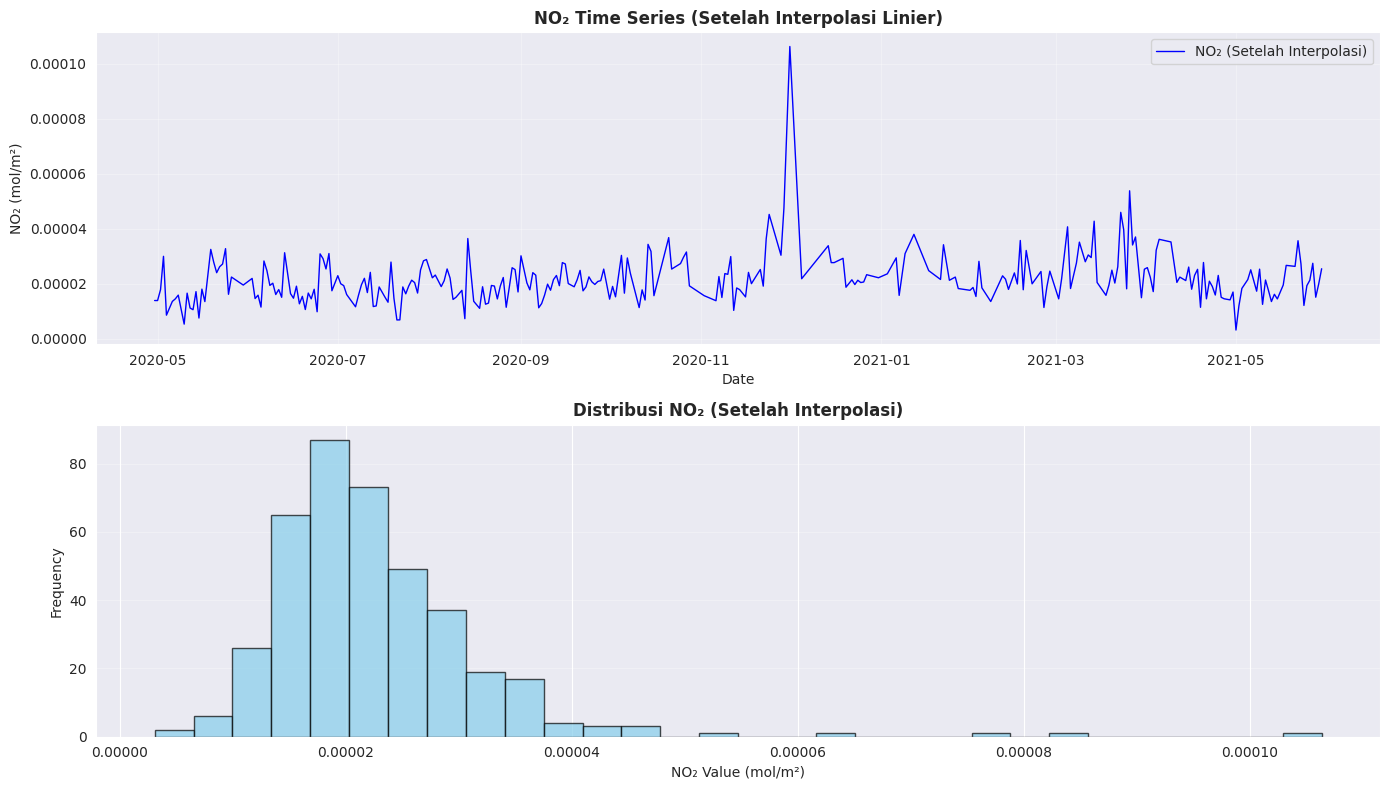


Preprocessing selesai


In [2]:
print("\n" + "="*70)
print("LANGKAH 2: PREPROCESSING - INTERPOLASI MISSING VALUES")
print("="*70)

# Baca data
df = pd.read_csv("timeseries.csv")
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").reset_index(drop=True)

# Cek missing values SEBELUM
missing_before = df["NO2"].isna().sum()
print(f"\nMissing values SEBELUM: {missing_before} ({missing_before/len(df)*100:.2f}%)")

# Interpolasi linier
df["NO2"] = df["NO2"].interpolate(method="linear")
df["NO2"] = df["NO2"].fillna(method="bfill").fillna(method="ffill")

# Cek missing values SESUDAH
missing_after = df["NO2"].isna().sum()
print(f"Missing values SESUDAH: {missing_after}")

# Statistik
print(f"\nStatistik NO2 setelah interpolasi:")
print(df["NO2"].describe())

# Visualisasi
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

axes[0].plot(df["date"], df["NO2"], color="blue", linewidth=1, label="NO₂ (Setelah Interpolasi)")
axes[0].set_title("NO₂ Time Series (Setelah Interpolasi Linier)", fontsize=12, fontweight="bold")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("NO₂ (mol/m²)")
axes[0].grid(True, alpha=0.3)
axes[0].legend()

axes[1].hist(df["NO2"], bins=30, edgecolor="black", alpha=0.7, color="skyblue")
axes[1].set_title("Distribusi NO₂ (Setelah Interpolasi)", fontsize=12, fontweight="bold")
axes[1].set_xlabel("NO₂ Value (mol/m²)")
axes[1].set_ylabel("Frequency")
axes[1].grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

print(f"\nPreprocessing selesai")

**💡 Penjelasan Singkat:**
- Data satelit sering memiliki missing values karena tutupan awan atau orbit satelit
- Menggunakan **interpolasi linear** untuk mengisi nilai yang hilang
- Interpolasi mengestimasi nilai berdasarkan data sebelum dan sesudahnya
- Metode ini mempertahankan trend data tanpa membuat outlier baru

### LANGKAH 3: Transformasi ke Supervised Learning

#### 📖 Penjelasan LANGKAH 3

**Tujuan:** Mengubah data time series menjadi format supervised learning yang bisa dipelajari oleh algoritma machine learning.

**Masalah Time Series:**
- Data time series asli: `[t1, t2, t3, t4, t5, ...]` (satu kolom)
- Machine learning butuh format: **fitur (X)** dan **target (y)**

**Transformasi dengan Lagged Features:**
```
Data Asli:           Menjadi:
t1                   
t2                   NO2(t-3)  NO2(t-2)  NO2(t-1)  |  NO2(t)
t3              →    t1        t2        t3        |  t4
t4                   t2        t3        t4        |  t5
t5                   t3        t4        t5        |  t6
```

**Penjelasan:**
- **Fitur (X):** 3 nilai NO₂ sebelumnya: `[NO2(t-3), NO2(t-2), NO2(t-1)]`
- **Target (y):** Nilai NO₂ yang ingin diprediksi: `NO2(t)`
- Setiap baris = 1 sampel training

**Mengapa 3 lag?**
- Berdasarkan analisis PACF
- Cukup untuk menangkap pattern temporal
- Tidak terlalu banyak (overfitting) atau sedikit (underfitting)

**Output:** DataFrame supervised dengan 3 kolom fitur + 1 kolom target

### Analisis Autokorelasi (ACF & PACF)

#### 📖 Penjelasan: Analisis Autokorelasi

**Tujuan:** Menentukan berapa banyak lag (data historis) yang optimal untuk prediksi.

**ACF (Autocorrelation Function):**
- Mengukur korelasi antara nilai sekarang dengan nilai lag sebelumnya
- Menunjukkan seberapa kuat pengaruh nilai-nilai sebelumnya terhadap nilai sekarang
- Lag yang keluar dari area confidence band (garis biru) = signifikan

**PACF (Partial Autocorrelation Function):**
- Mengukur korelasi murni antara nilai sekarang dengan lag tertentu, **tanpa pengaruh lag perantara**
- Lebih akurat untuk menentukan jumlah lag optimal
- Contoh: PACF(3) mengukur pengaruh t-3 ke t, tanpa pengaruh t-2 dan t-1

**Interpretasi:**
- Jika PACF signifikan pada lag 1, 2, 3 → gunakan 3 lag
- Confidence interval: ±1.96/√n (95% confidence level)
- Lag signifikan = nilai PACF keluar dari confidence band

**Kegunaan:** Membantu memilih jumlah fitur lag yang optimal untuk model KNN Regression


ANALISIS AUTOKORELASI (ACF & PACF)


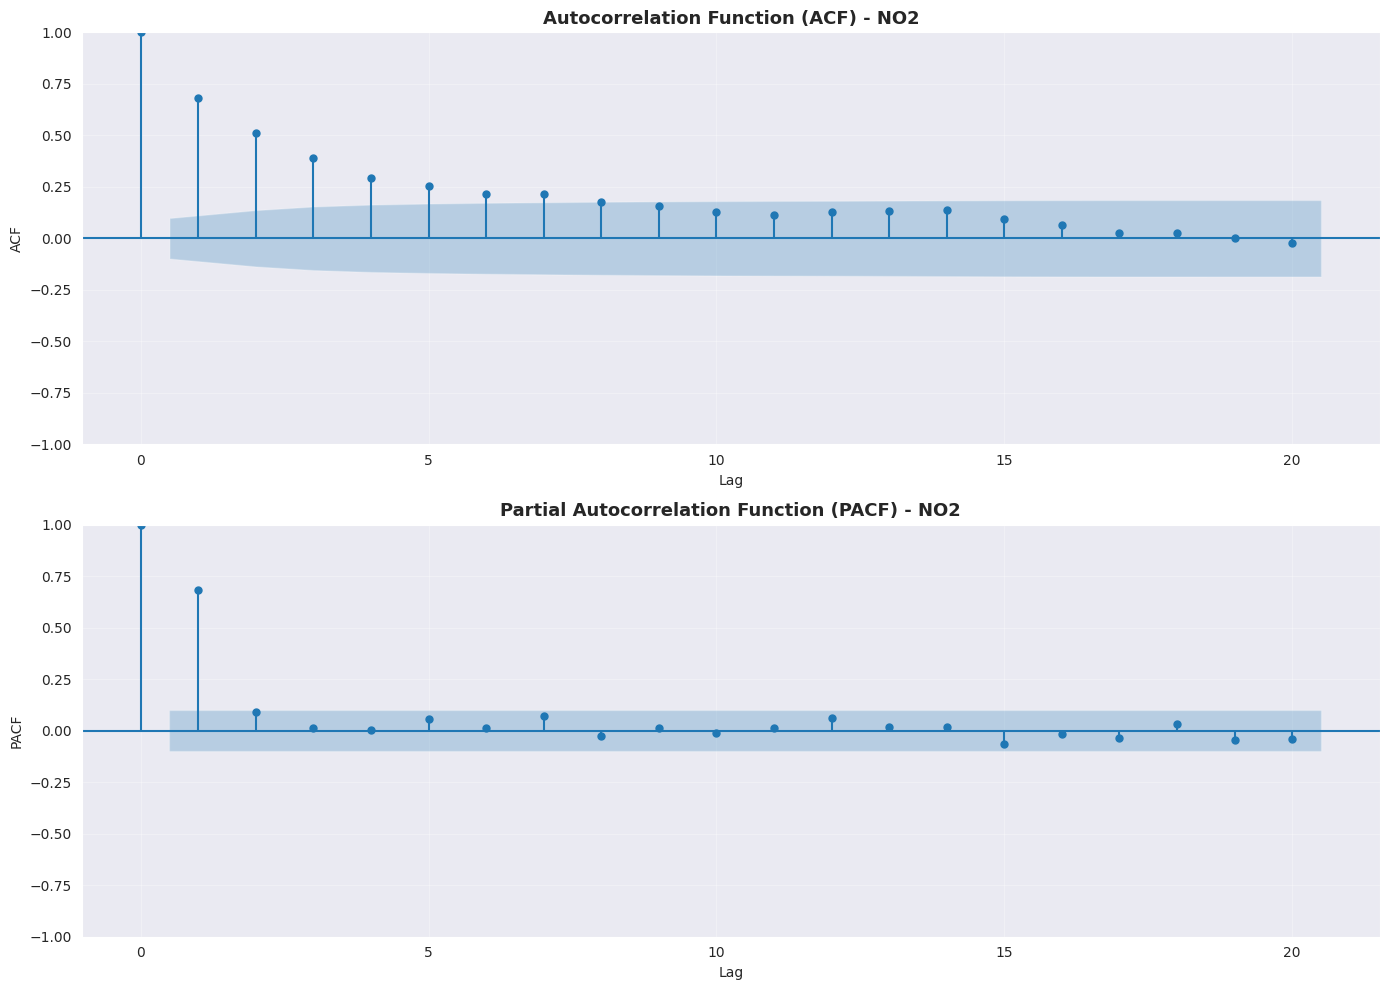


Lag yang signifikan (berdasarkan PACF): [1]
Rekomendasi jumlah lag optimal: 1

REKOMENDASI LAG

⚠ PERHATIAN: PACF hanya menunjukkan 1 lag signifikan
   Namun untuk time series, minimal 3 lag tetap direkomendasikan

Catatan: Sel berikutnya akan menggunakan 3 lag sebagai default


In [3]:
print("\n" + "="*70)
print("ANALISIS AUTOKORELASI (ACF & PACF)")
print("="*70)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

# Hitung ACF dan PACF
acf_values = acf(df["NO2"], nlags=20)
pacf_values = pacf(df["NO2"], nlags=20)

# Visualisasi ACF dan PACF
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot ACF
plot_acf(df["NO2"], lags=20, ax=axes[0], alpha=0.05)
axes[0].set_title('Autocorrelation Function (ACF) - NO2', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('ACF')
axes[0].grid(True, alpha=0.3)

# Plot PACF
plot_pacf(df["NO2"], lags=20, ax=axes[1], alpha=0.05, method='ywm')
axes[1].set_title('Partial Autocorrelation Function (PACF) - NO2', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('PACF')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analisis optimal lag berdasarkan PACF
significant_lags = []
for i, val in enumerate(pacf_values[1:], 1):  # Skip lag 0
    if abs(val) > 1.96/np.sqrt(len(df)):  # 95% confidence interval
        significant_lags.append(i)

print(f"\nLag yang signifikan (berdasarkan PACF): {significant_lags[:5]}")
print(f"Rekomendasi jumlah lag optimal: {len(significant_lags[:5])}")

# Saran untuk improvement
recommended_lags = len(significant_lags[:5])
print(f"\n{'='*70}")
print("REKOMENDASI LAG")
print(f"{'='*70}")
if recommended_lags > 3:
    print(f"\n💡 SARAN: Pertimbangkan menggunakan {recommended_lags} lag untuk meningkatkan performa model")
    print(f"   Lag yang direkomendasikan berdasarkan PACF signifikan")
elif recommended_lags < 3:
    print(f"\n⚠ PERHATIAN: PACF hanya menunjukkan {recommended_lags} lag signifikan")
    print(f"   Namun untuk time series, minimal 3 lag tetap direkomendasikan")
else:
    print(f"\n✓ OPTIMAL: Jumlah lag yang direkomendasikan adalah {recommended_lags}")
    print(f"   Sesuai dengan analisis PACF")

print(f"\nCatatan: Sel berikutnya akan menggunakan 3 lag sebagai default")

**💡 Penjelasan Singkat:**
- **ACF** (Autocorrelation): Mengukur korelasi nilai sekarang dengan nilai sebelumnya
- **PACF** (Partial Autocorrelation): Mengukur korelasi murni tanpa pengaruh lag perantara
- Digunakan untuk menentukan **jumlah lag optimal** untuk model prediksi
- Lag signifikan = nilai yang keluar dari confidence band (garis biru)

In [4]:
print("\n" + "="*70)
print("LANGKAH 3: TRANSFORMASI KE SUPERVISED LEARNING")
print("="*70)

def series_to_supervised(data, n_in=1, n_out=1, dropna=True):
    """
    Konversi time series menjadi supervised learning dataset.
    """
    df_data = pd.DataFrame(data)
    cols, names = [], []

    # Input sequence (t-n, ..., t-1)
    for i in range(n_in, 0, -1):
        cols.append(df_data.shift(i))
        names += [f"NO2(t-{i})"]

    # Output sequence (t)
    for i in range(0, n_out):
        cols.append(df_data.shift(-i))
        if i == 0:
            names += ["NO2(t)"]
        else:
            names += [f"NO2(t+{i})"]

    agg = pd.concat(cols, axis=1)
    agg.columns = names

    if dropna:
        agg.dropna(inplace=True)

    return agg

# Gunakan 3 lag
n_lags = 3
supervised_df = series_to_supervised(df[["NO2"]], n_in=n_lags, n_out=1)

print(f"\nTransformasi supervised learning dengan lag={n_lags}")
print(f"  - Total samples: {len(supervised_df)}")
print(f"  - Input fitur: {n_lags} (t-1 hingga t-{n_lags})")
print(f"  - Target: 1 (t)")
print(f"\nData pertama (5 baris):")
print(supervised_df.head())


LANGKAH 3: TRANSFORMASI KE SUPERVISED LEARNING

Transformasi supervised learning dengan lag=3
  - Total samples: 393
  - Input fitur: 3 (t-1 hingga t-3)
  - Target: 1 (t)

Data pertama (5 baris):
   NO2(t-3)  NO2(t-2)  NO2(t-1)    NO2(t)
3  0.000014  0.000014  0.000018  0.000030
4  0.000014  0.000018  0.000030  0.000009
5  0.000018  0.000030  0.000009  0.000011
6  0.000030  0.000009  0.000011  0.000014
7  0.000009  0.000011  0.000014  0.000014


**💡 Penjelasan Singkat:**
- Mengubah data time series menjadi format **supervised learning**
- Membuat **lagged features**: gunakan 3 nilai sebelumnya `[t-3, t-2, t-1]` untuk prediksi nilai sekarang `[t]`
- Setiap baris = 1 sampel training dengan format: **Fitur (X)** → 3 lag, **Target (y)** → nilai yang diprediksi
- Transformasi ini memungkinkan algoritma ML untuk belajar dari pola temporal

### LANGKAH 4: Normalisasi Data


#### 📖 Penjelasan LANGKAH 4

**Tujuan:** Mengubah skala data agar semua fitur berada dalam rentang yang sama (0-1).

**Mengapa perlu normalisasi?**
1. **KNN sensitif terhadap skala:** KNN menggunakan distance (jarak Euclidean), jika satu fitur punya nilai besar, dia akan mendominasi perhitungan jarak
2. **Meningkatkan performa:** Algoritma konvergen lebih cepat dengan data ternormalisasi
3. **Menghindari bias:** Semua fitur berkontribusi sama dalam perhitungan

**MinMaxScaler:**
- Formula: `X_scaled = (X - X_min) / (X_max - X_min)`
- Mengubah data ke rentang [0, 1]
- Min → 0, Max → 1
- Mempertahankan distribusi data

**Proses Penting:**
1. **Pisahkan data dulu** menjadi train-test (80:20)
2. **Fit scaler HANYA pada training set** → dapatkan parameter (min, max)
3. **Transform training set** dengan parameter tersebut
4. **Transform testing set** dengan parameter yang SAMA dari training
   - ⚠️ **Jangan fit ulang di testing!** (ini menyebabkan data leakage)

**Mengapa shuffle=False?**
- Time series punya urutan temporal yang penting
- Training = data lama, Testing = data baru (simulasi prediksi masa depan)

**Output:** Data training dan testing yang sudah ternormalisasi ke [0, 1]


LANGKAH 4: NORMALISASI DATA

Memisahkan data menjadi training dan testing...

Pembagian Data:
  - Set Training: 314 sampel (79.9%)
  - Set Testing: 79 sampel (20.1%)

Metode Normalisasi: MinMaxScaler
  - Formula: (x - min) / (max - min)
  - Range: [0, 1]
  - Min hasil: 0, Max hasil: 1

Statistik SEBELUM normalisasi:
         NO2(t-3)    NO2(t-2)    NO2(t-1)      NO2(t)
count  393.000000  393.000000  393.000000  393.000000
mean     0.000022    0.000022    0.000022    0.000023
std      0.000010    0.000010    0.000010    0.000010
min      0.000003    0.000003    0.000003    0.000003
25%      0.000017    0.000017    0.000017    0.000017
50%      0.000021    0.000021    0.000021    0.000021
75%      0.000026    0.000026    0.000026    0.000026
max      0.000106    0.000106    0.000106    0.000106

Normalisasi selesai

Statistik SESUDAH normalisasi (set training):
         NO2(t-3)    NO2(t-2)    NO2(t-1)
count  314.000000  314.000000  314.000000
mean     0.167867    0.168424    0.168869
s

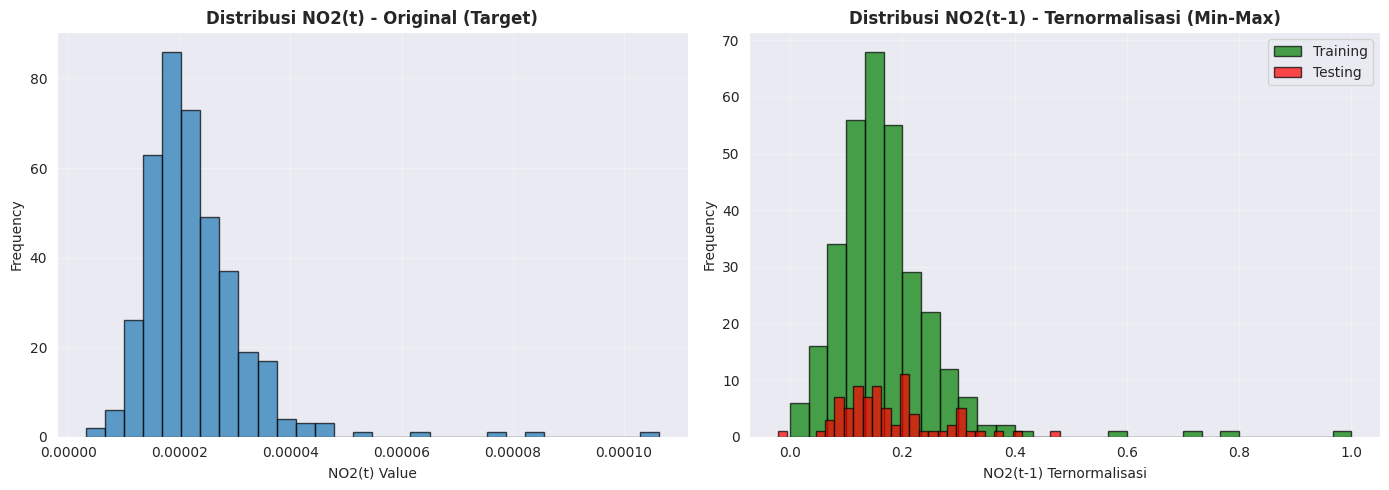

In [5]:
print("\n" + "="*70)
print("LANGKAH 4: NORMALISASI DATA")
print("="*70)

# Pisahkan data terlebih dahulu (sebelum normalisasi)
print("\nMemisahkan data menjadi training dan testing...")
X_features = supervised_df.iloc[:, :-1]  # Semua kolom kecuali NO2(t)
y_target = supervised_df.iloc[:, -1]     # Hanya kolom NO2(t)

# Pembagian train-test (80-20, shuffle=False untuk time series)
X_train, X_test, y_train, y_test = train_test_split(
    X_features, y_target, test_size=0.2, random_state=42, shuffle=False
)

print(f"\nPembagian Data:")
print(f"  - Set Training: {len(X_train)} sampel ({len(X_train)/len(X_features)*100:.1f}%)")
print(f"  - Set Testing: {len(X_test)} sampel ({len(X_test)/len(X_features)*100:.1f}%)")

# MinMaxScaler
scaler = MinMaxScaler()

print(f"\nMetode Normalisasi: MinMaxScaler")
print(f"  - Formula: (x - min) / (max - min)")
print(f"  - Range: [0, 1]")
print(f"  - Min hasil: 0, Max hasil: 1")

# Statistik SEBELUM normalisasi
print(f"\nStatistik SEBELUM normalisasi:")
print(supervised_df.describe())

# Fit scaler HANYA pada data training
scaler.fit(X_train)

# Transform data training dan testing menggunakan parameter dari training
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Buat DataFrame dengan fitur yang sudah dinormalisasi
train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_features.columns, index=X_train.index)
test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_features.columns, index=X_test.index)

# Statistik SESUDAH normalisasi
print(f"\nNormalisasi selesai")
print(f"\nStatistik SESUDAH normalisasi (set training):")
print(train_scaled_df.describe())

print(f"\nStatistik SESUDAH normalisasi (set testing):")
print(test_scaled_df.describe())

# Visualisasi
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(y_target, bins=30, edgecolor="black", alpha=0.7)
axes[0].set_title("Distribusi NO2(t) - Original (Target)", fontsize=12, fontweight="bold")
axes[0].set_xlabel("NO2(t) Value")
axes[0].set_ylabel("Frequency")
axes[0].grid(True, alpha=0.3)

axes[1].hist(train_scaled_df["NO2(t-1)"], bins=30, edgecolor="black", alpha=0.7, color="green", 
             label="Training")
axes[1].hist(test_scaled_df["NO2(t-1)"], bins=30, edgecolor="black", alpha=0.7, color="red", 
             label="Testing")
axes[1].set_title("Distribusi NO2(t-1) - Ternormalisasi (Min-Max)", fontsize=12, fontweight="bold")
axes[1].set_xlabel("NO2(t-1) Ternormalisasi")
axes[1].set_ylabel("Frequency")
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

**💡 Penjelasan Singkat:**
- **Normalisasi** mengubah skala data ke rentang [0, 1] menggunakan **MinMaxScaler**
- KNN sensitif terhadap skala → normalisasi memastikan semua fitur berkontribusi sama
- **Penting:** Fit scaler HANYA pada training set, lalu transform training & testing
- Pisah data: 80% training, 20% testing (shuffle=False untuk time series)

### LANGKAH 5: Definisikan Batas Ambang (Threshold) dan Buat Labels

#### 📖 Penjelasan LANGKAH 5

**Tujuan:** Menentukan batas ambang (threshold) untuk mengklasifikasikan NO₂ sebagai AMAN atau BERBAHAYA.

**Mengapa butuh threshold?**
- Model KNN Regression menghasilkan **nilai kontinu** NO₂ (misal: 0.00012345 mol/m²)
- Kita butuh **klasifikasi biner** untuk interpretasi mudah: AMAN atau BERBAHAYA
- Threshold = nilai batas pemisah antara kedua kelas

**Metode: 75th Percentile**
- **Persentil ke-75** = nilai yang memisahkan 75% data terkecil dari 25% data terbesar
- 75% data akan berlabel AMAN (0)
- 25% data akan berlabel BERBAHAYA (1)
- Lebih objektif daripada menentukan threshold secara manual

**Alternatif metode threshold:**
- Standar WHO/pemerintah (jika ada)
- Mean/median data
- Persentil lain (50th, 80th, 90th)

**Penerapan:**
```
Jika NO2 ≤ threshold → Label 0 (AMAN)
Jika NO2 > threshold  → Label 1 (BERBAHAYA)
```

**Catatan:** Threshold ini akan digunakan untuk:
1. Evaluasi model (klasifikasi metrik)
2. Interpretasi prediksi hari besok

**Output:** Nilai threshold dan distribusi label biner untuk seluruh dataset


LANGKAH 5: DEFINISIKAN THRESHOLD DAN BUAT LABELS

Definisi Threshold:
  - Menggunakan: 75th percentile
  - Nilai threshold: 0.00002603 mol/m²

  - Label 0 (AMAN):      NO2 ≤ 0.00002603
  - Label 1 (BERBAHAYA): NO2 > 0.00002603

Distribusi Label (Seluruh Dataset):
  - Label 0 (AMAN):      295 sampel (75.1%)
  - Label 1 (BERBAHAYA): 98 sampel (24.9%)


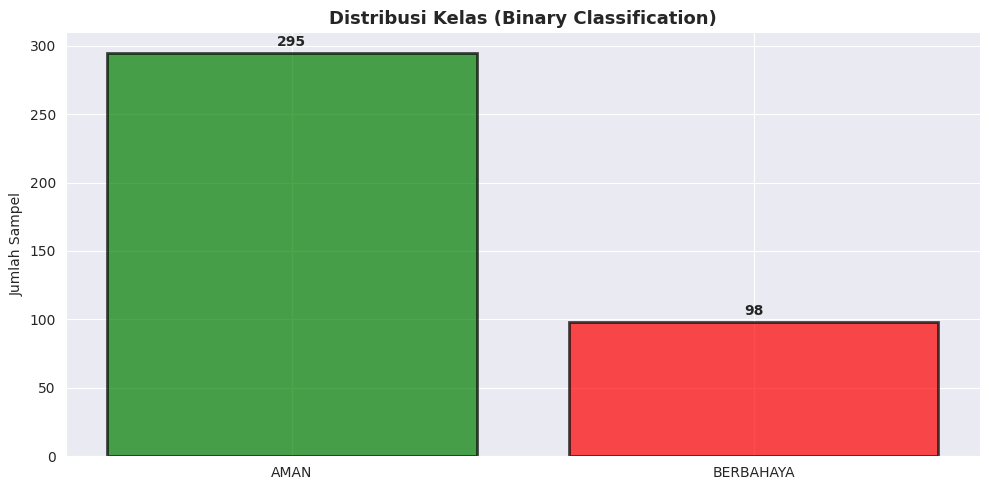


Threshold berhasil didefinisikan


In [6]:
print("\n" + "="*70)
print("LANGKAH 5: DEFINISIKAN THRESHOLD DAN BUAT LABELS")
print("="*70)

# Gunakan 75th percentile sebagai threshold
threshold = supervised_df["NO2(t)"].quantile(0.75)

print(f"\nDefinisi Threshold:")
print(f"  - Menggunakan: 75th percentile")
print(f"  - Nilai threshold: {threshold:.8f} mol/m²")
print(f"\n  - Label 0 (AMAN):      NO2 ≤ {threshold:.8f}")
print(f"  - Label 1 (BERBAHAYA): NO2 > {threshold:.8f}")

# Buat binary labels untuk seluruh data supervised
binary_labels = (supervised_df["NO2(t)"] > threshold).astype(int)

# Statistik label untuk seluruh dataset
print(f"\nDistribusi Label (Seluruh Dataset):")
label_counts = binary_labels.value_counts().sort_index()
print(f"  - Label 0 (AMAN):      {label_counts[0]} sampel ({label_counts[0]/len(binary_labels)*100:.1f}%)")
print(f"  - Label 1 (BERBAHAYA): {label_counts[1]} sampel ({label_counts[1]/len(binary_labels)*100:.1f}%)")

# Visualisasi class distribution
fig, ax = plt.subplots(figsize=(10, 5))
labels_text = ['AMAN', 'BERBAHAYA']
colors_bar = ['green', 'red']
ax.bar(labels_text, label_counts.values, color=colors_bar, alpha=0.7, edgecolor='black', linewidth=2)
ax.set_title('Distribusi Kelas (Binary Classification)', fontsize=13, fontweight='bold')
ax.set_ylabel('Jumlah Sampel')
for i, v in enumerate(label_counts.values):
    ax.text(i, v + 5, str(v), ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nThreshold berhasil didefinisikan")

**💡 Penjelasan Singkat:**
- Menentukan **threshold** (batas ambang) untuk klasifikasi biner: AMAN vs BERBAHAYA
- Menggunakan **persentil ke-75** sebagai threshold (objektif dan data-driven)
- 75% data → Label 0 (AMAN), 25% data → Label 1 (BERBAHAYA)
- Threshold digunakan untuk evaluasi klasifikasi dan interpretasi prediksi

# Modelling

### LANGKAH 6: KNN Regression Modeling


#### 📖 Penjelasan LANGKAH 6

**Tujuan:** Membangun model KNN Regression dan menemukan hyperparameter terbaik melalui Grid Search.

**KNN Regression:**
- **K-Nearest Neighbors Regression** = algoritma yang memprediksi nilai berdasarkan K tetangga terdekat
- Cara kerja:
  1. Hitung jarak data baru ke semua data training
  2. Ambil K tetangga terdekat
  3. Rata-rata nilai NO₂ dari K tetangga → prediksi

**Hyperparameter yang dioptimasi:**
1. **n_neighbors (K):** Jumlah tetangga terdekat (2, 3, 5, 7, 9, 11, 13, 15)
   - K kecil → sensitif, bisa overfit
   - K besar → smooth, bisa underfit
   
2. **weights:** Bobot tetangga
   - `uniform`: Semua tetangga bobotnya sama
   - `distance`: Tetangga lebih dekat = bobot lebih besar
   
3. **metric:** Metode hitung jarak
   - `euclidean`: Jarak garis lurus (paling umum)
   - `manhattan`: Jarak sepanjang grid (city-block)
   - `minkowski`: Generalisasi euclidean & manhattan

**Grid Search + 5-Fold Cross Validation:**
- Mencoba **semua kombinasi** hyperparameter (8×2×3 = 48 kombinasi)
- Setiap kombinasi dievaluasi dengan **5-fold CV**: data dibagi 5, training 4 bagian, validasi 1 bagian (diulang 5x)
- Pilih kombinasi dengan **MSE terkecil**

**Evaluasi:**
- **MSE** (Mean Squared Error): Rata-rata kuadrat error
- **RMSE** (Root MSE): Akar MSE, dalam unit asli
- **MAE** (Mean Absolute Error): Rata-rata error absolut
- **MAPE** (Mean Absolute Percentage Error): Error dalam persen
- **R²** (R-squared): Proporsi variansi yang dijelaskan (0-1, makin besar makin bagus)

**Output:** Model KNN terbaik dengan hyperparameter optimal

In [1]:
print("\n" + "="*70)
print("LANGKAH 6: KNN REGRESSION MODELING - OPTIMASI HYPERPARAMETER")
print("="*70)

# Import library yang diperlukan
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

print(f"\nData Siap:")
print(f"  - Bentuk fitur training: {X_train_scaled.shape} (3 fitur lag - ternormalisasi)")
print(f"  - Bentuk fitur testing: {X_test_scaled.shape} (3 fitur lag - ternormalisasi)")
print(f"  - Range target: [{y_target.min():.8f}, {y_target.max():.8f}] mol/m²")

# Parameter grid untuk optimasi
param_grid = {
    'n_neighbors': [2, 3, 5, 7, 9, 11, 13, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

print(f"\n{'='*70}")
print("OPTIMASI HYPERPARAMETER DENGAN GRID SEARCH + 5-FOLD CROSS VALIDATION")
print(f"{'='*70}")
print(f"\nMencari kombinasi hyperparameter terbaik...")
print(f"  - Parameter n_neighbors: {param_grid['n_neighbors']}")
print(f"  - Parameter weights: {param_grid['weights']}")
print(f"  - Parameter metric: {param_grid['metric']}")
print(f"  - Total kombinasi: {len(param_grid['n_neighbors']) * len(param_grid['weights']) * len(param_grid['metric'])}")
print(f"  - Cross-validation folds: 5")
print(f"\nProses optimasi sedang berjalan (ini bisa memakan waktu beberapa menit)...")

# Grid Search dengan Cross Validation
knn_grid = GridSearchCV(
    KNeighborsRegressor(),
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

knn_grid.fit(X_train_scaled, y_train)

print(f"\n✓ Grid Search selesai!")
print(f"\n{'='*70}")
print("HASIL OPTIMASI")
print(f"{'='*70}")
print(f"\nParameter Terbaik:")
print(f"  - n_neighbors (K): {knn_grid.best_params_['n_neighbors']}")
print(f"  - weights: {knn_grid.best_params_['weights']}")
print(f"  - metric: {knn_grid.best_params_['metric']}")
print(f"  - Best CV Score (neg_MSE): {knn_grid.best_score_:.10f}")
print(f"  - Best CV Score (MSE): {-knn_grid.best_score_:.10f}")

# Model terbaik dari Grid Search
optimized_model = knn_grid.best_estimator_
y_pred_optimized = optimized_model.predict(X_test_scaled)

# Evaluasi model optimized pada test set
mse = mean_squared_error(y_test, y_pred_optimized)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_optimized)
mape = mean_absolute_percentage_error(y_test, y_pred_optimized) * 100
r2 = r2_score(y_test, y_pred_optimized)

print(f"\n{'='*70}")
print("PERFORMA MODEL PADA TEST SET")
print(f"{'='*70}")
print(f"  - MSE:  {mse:.10f}")
print(f"  - RMSE: {rmse:.10f}")
print(f"  - MAE:  {mae:.10f}")
print(f"  - MAPE: {mape:.2f}%")
print(f"  - R²:   {r2:.4f}")

# Simpan parameter terbaik untuk digunakan di sel berikutnya
best_k = knn_grid.best_params_['n_neighbors']
best_weights = knn_grid.best_params_['weights']
best_metric = knn_grid.best_params_['metric']

# Untuk compatibility dengan sel deployment
best_k_optimized = best_k
mse_opt = mse
rmse_opt = rmse
mae_opt = mae
mape_opt = mape
r2_opt = r2

print(f"\n{'='*70}")
print("ANALISIS GRID SEARCH RESULTS")
print(f"{'='*70}")

# Konversi hasil ke DataFrame untuk analisis
results_df = pd.DataFrame(knn_grid.cv_results_)

# Tampilkan top 5 kombinasi terbaik
print(f"\nTop 5 Kombinasi Hyperparameter Terbaik:")
top_5 = results_df.nsmallest(5, 'rank_test_score')[['param_n_neighbors', 'param_weights', 'param_metric', 'mean_test_score', 'std_test_score']]
top_5['mean_test_score_positive'] = -top_5['mean_test_score']  # Konversi ke MSE positif
print(top_5[['param_n_neighbors', 'param_weights', 'param_metric', 'mean_test_score_positive', 'std_test_score']].to_string(index=False))

# Visualisasi performa Grid Search
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: MSE vs K untuk setiap kombinasi weights dan metric
for weight in param_grid['weights']:
    for metric in param_grid['metric']:
        mask = (results_df['param_weights'] == weight) & (results_df['param_metric'] == metric)
        subset = results_df[mask].sort_values('param_n_neighbors')
        label = f"{weight}, {metric}"
        axes[0, 0].plot(subset['param_n_neighbors'], -subset['mean_test_score'], 
                       marker='o', label=label, linewidth=2, markersize=6)

axes[0, 0].axvline(x=best_k, color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Best K={best_k}')
axes[0, 0].set_xlabel('Nilai K (n_neighbors)', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('MSE (Cross-Validation)', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Grid Search: MSE vs K untuk Berbagai Kombinasi', fontsize=13, fontweight='bold')
axes[0, 0].legend(fontsize=9, loc='best')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xticks(param_grid['n_neighbors'])

# Plot 2: Perbandingan weights
weight_comparison = results_df.groupby('param_weights')['mean_test_score'].mean()
axes[0, 1].bar(range(len(weight_comparison)), -weight_comparison.values, 
              color=['skyblue', 'salmon'], edgecolor='black', linewidth=2, alpha=0.8)
axes[0, 1].set_xticks(range(len(weight_comparison)))
axes[0, 1].set_xticklabels(weight_comparison.index, fontsize=11)
axes[0, 1].set_ylabel('Average MSE', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Perbandingan Weights (Average MSE)', fontsize=13, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(-weight_comparison.values):
    axes[0, 1].text(i, v, f'{v:.10f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# Plot 3: Perbandingan metric
metric_comparison = results_df.groupby('param_metric')['mean_test_score'].mean()
axes[1, 0].bar(range(len(metric_comparison)), -metric_comparison.values, 
              color=['lightgreen', 'lightcoral', 'lightyellow'], edgecolor='black', linewidth=2, alpha=0.8)
axes[1, 0].set_xticks(range(len(metric_comparison)))
axes[1, 0].set_xticklabels(metric_comparison.index, fontsize=11)
axes[1, 0].set_ylabel('Average MSE', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Perbandingan Distance Metric (Average MSE)', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(-metric_comparison.values):
    axes[1, 0].text(i, v, f'{v:.10f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# Plot 4: Heatmap MSE berdasarkan K dan weights (untuk metric terbaik)
pivot_data = results_df[results_df['param_metric'] == best_metric].pivot_table(
    values='mean_test_score', 
    index='param_weights', 
    columns='param_n_neighbors'
)
pivot_data = -pivot_data  # Konversi ke MSE positif

im = axes[1, 1].imshow(pivot_data.values, cmap='RdYlGn_r', aspect='auto', interpolation='nearest')
axes[1, 1].set_xticks(range(len(pivot_data.columns)))
axes[1, 1].set_yticks(range(len(pivot_data.index)))
axes[1, 1].set_xticklabels(pivot_data.columns)
axes[1, 1].set_yticklabels(pivot_data.index)
axes[1, 1].set_xlabel('K (n_neighbors)', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Weights', fontsize=12, fontweight='bold')
axes[1, 1].set_title(f'Heatmap MSE (metric={best_metric})', fontsize=13, fontweight='bold')

# Tambahkan colorbar
cbar = plt.colorbar(im, ax=axes[1, 1])
cbar.set_label('MSE', fontsize=11, fontweight='bold')

# Tambahkan nilai MSE di setiap sel
for i in range(len(pivot_data.index)):
    for j in range(len(pivot_data.columns)):
        text = axes[1, 1].text(j, i, f'{pivot_data.values[i, j]:.2e}',
                              ha="center", va="center", color="black", fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n✓ Model KNN Regression telah dioptimasi dengan Grid Search!")
print(f"✓ Model terbaik akan digunakan untuk evaluasi dan prediksi selanjutnya.")



LANGKAH 6: KNN REGRESSION MODELING - OPTIMASI HYPERPARAMETER

Data Siap:


NameError: name 'X_train_scaled' is not defined

**💡 Penjelasan Singkat:**
- Membangun model **KNN Regression** untuk memprediksi nilai NO₂ kontinu
- **Grid Search** mencoba 48 kombinasi hyperparameter (K, weights, metric)
- **5-Fold Cross Validation** untuk evaluasi robust dan pilih kombinasi terbaik
- Metrik evaluasi: MSE, RMSE, MAE, MAPE, R²
- Output: Model optimal dengan hyperparameter terbaik

### LANGKAH 7: Evaluasi Regression & Threshold Application

#### 📖 Penjelasan LANGKAH 7

**Tujuan:** Mengevaluasi performa model dari dua perspektif: **Regresi** dan **Klasifikasi** (setelah threshold).

**[A] Evaluasi Regresi:**
Model memprediksi **nilai kontinu** NO₂, dievaluasi dengan:
- **MSE/RMSE:** Mengukur seberapa jauh prediksi dari nilai aktual (penalti besar untuk error besar)
- **MAE:** Rata-rata error absolut (lebih robust terhadap outlier)
- **MAPE:** Error dalam persentase (mudah diinterpretasi)
- **R²:** Seberapa baik model menjelaskan variansi data (1 = sempurna, 0 = buruk)

**[B] Evaluasi Klasifikasi (Setelah Threshold):**
Setelah menerapkan threshold pada prediksi kontinu, evaluasi sebagai **klasifikasi biner**:

1. **Akurasi:** Persentase prediksi yang benar
   - Formula: `(TP + TN) / Total`
   
2. **Presisi:** Dari yang diprediksi BERBAHAYA, berapa yang benar-benar BERBAHAYA
   - Formula: `TP / (TP + FP)`
   - Penting untuk menghindari false alarm
   
3. **Recall:** Dari yang benar-benar BERBAHAYA, berapa yang berhasil terdeteksi
   - Formula: `TP / (TP + FN)`
   - Penting untuk keselamatan (jangan sampai miss kasus berbahaya!)
   
4. **F1-Score:** Harmonic mean antara presisi dan recall
   - Formula: `2 × (Presisi × Recall) / (Presisi + Recall)`
   - Balance antara presisi dan recall

**Confusion Matrix:**
```
                 Prediksi AMAN  |  Prediksi BERBAHAYA
Aktual AMAN      TN (benar)    |  FP (false alarm)
Aktual BERBAHAYA FN (terlewat) |  TP (benar)
```

**Visualisasi:**
- Scatter plot: Aktual vs Prediksi (cek linearitas)
- Residual plot: Error vs Prediksi (cek heteroskedastisitas)
- Time series: Membandingkan prediksi dengan aktual sepanjang waktu
- Confusion matrix: Visualisasi klasifikasi biner

**Output:** Metrik lengkap untuk regresi & klasifikasi, plus visualisasi comprehensive


LANGKAH 7: EVALUASI REGRESSION & THRESHOLD APPLICATION

[A] METRIK REGRESI (K=5):
  - MSE:  0.0000000001
  - RMSE: 0.0000080251
  - MAE:  0.0000060256
  - MAPE: 32.57%
  - R²:   0.1300

[B] METRIK KLASIFIKASI (Setelah Threshold):
  - Threshold: 0.00002603 mol/m²
  - Akurasi:   0.7975
  - Presisi:   0.6842
  - Recall:    0.5652
  - F1-Score:  0.6190

Confusion Matrix:
  - True Negatives (AMAN diprediksi AMAN):         50
  - False Positives (AMAN diprediksi BERBAHAYA):  6
  - False Negatives (BERBAHAYA diprediksi AMAN):  10
  - True Positives (BERBAHAYA diprediksi BERBAHAYA): 13


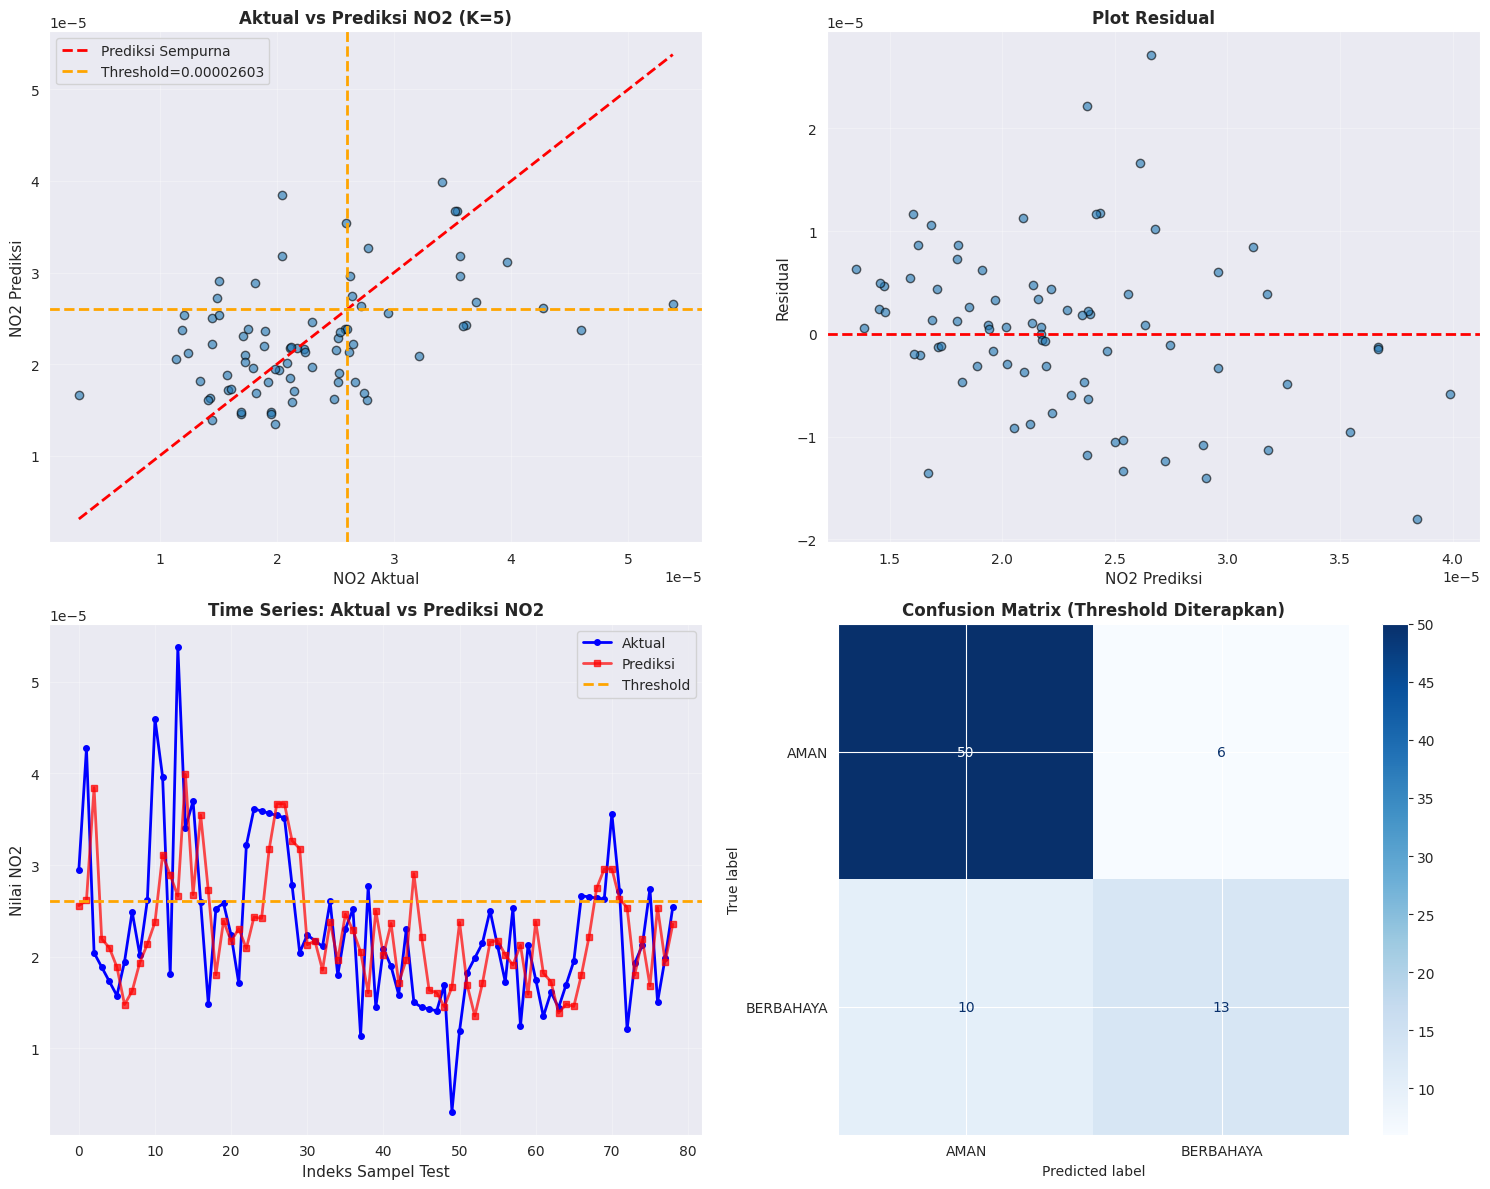


Laporan Klasifikasi (Setelah Threshold):
              precision    recall  f1-score   support

        AMAN       0.83      0.89      0.86        56
   BERBAHAYA       0.68      0.57      0.62        23

    accuracy                           0.80        79
   macro avg       0.76      0.73      0.74        79
weighted avg       0.79      0.80      0.79        79



In [ ]:
print("\n" + "="*70)
print("LANGKAH 7: EVALUASI REGRESSION & THRESHOLD APPLICATION")
print("="*70)

# Gunakan model yang sudah dioptimasi dari Grid Search
final_model = optimized_model
best_k = int(best_k)

# Prediksi nilai NO2 (kontinu) - sudah dilakukan di sel sebelumnya
y_pred_regression = y_pred_optimized

# Hitung metrik regresi
mse = mean_squared_error(y_test, y_pred_regression)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_regression)
mape = mean_absolute_percentage_error(y_test, y_pred_regression) * 100  # dalam persen
r2 = r2_score(y_test, y_pred_regression)

print(f"\n[A] METRIK REGRESI (K={best_k}):")
print(f"  - MSE:  {mse:.10f}")
print(f"  - RMSE: {rmse:.10f}")
print(f"  - MAE:  {mae:.10f}")
print(f"  - MAPE: {mape:.2f}%")
print(f"  - R²:   {r2:.4f}")

# Terapkan threshold pada prediksi
y_test_binary = (y_test > threshold).astype(int)
y_pred_binary = (y_pred_regression > threshold).astype(int)

# Hitung metrik klasifikasi setelah threshold
accuracy = accuracy_score(y_test_binary, y_pred_binary)
precision = precision_score(y_test_binary, y_pred_binary, zero_division=0)
recall = recall_score(y_test_binary, y_pred_binary, zero_division=0)
f1 = f1_score(y_test_binary, y_pred_binary, zero_division=0)

print(f"\n[B] METRIK KLASIFIKASI (Setelah Threshold):")
print(f"  - Threshold: {threshold:.8f} mol/m²")
print(f"  - Akurasi:   {accuracy:.4f}")
print(f"  - Presisi:   {precision:.4f}")
print(f"  - Recall:    {recall:.4f}")
print(f"  - F1-Score:  {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test_binary, y_pred_binary)
tn, fp, fn, tp = cm.ravel()

print(f"\nConfusion Matrix:")
print(f"  - True Negatives (AMAN diprediksi AMAN):         {tn}")
print(f"  - False Positives (AMAN diprediksi BERBAHAYA):  {fp}")
print(f"  - False Negatives (BERBAHAYA diprediksi AMAN):  {fn}")
print(f"  - True Positives (BERBAHAYA diprediksi BERBAHAYA): {tp}")

# Visualisasi
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Aktual vs Prediksi (Regresi)
axes[0, 0].scatter(y_test, y_pred_regression, alpha=0.6, edgecolors='k')
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Prediksi Sempurna')
axes[0, 0].axhline(y=threshold, color='orange', linestyle='--', linewidth=2, label=f'Threshold={threshold:.8f}')
axes[0, 0].axvline(x=threshold, color='orange', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('NO2 Aktual', fontsize=11)
axes[0, 0].set_ylabel('NO2 Prediksi', fontsize=11)
axes[0, 0].set_title(f'Aktual vs Prediksi NO2 (K={best_k})', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Residual Plot
residuals = y_test - y_pred_regression
axes[0, 1].scatter(y_pred_regression, residuals, alpha=0.6, edgecolors='k')
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('NO2 Prediksi', fontsize=11)
axes[0, 1].set_ylabel('Residual', fontsize=11)
axes[0, 1].set_title('Plot Residual', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Perbandingan Time Series
test_indices = range(len(y_test))
axes[1, 0].plot(test_indices, y_test, label='Aktual', color='blue', linewidth=2, marker='o', markersize=4)
axes[1, 0].plot(test_indices, y_pred_regression, label='Prediksi', color='red', linewidth=2, marker='s', markersize=4, alpha=0.7)
axes[1, 0].axhline(y=threshold, color='orange', linestyle='--', linewidth=2, label=f'Threshold')
axes[1, 0].set_xlabel('Indeks Sampel Test', fontsize=11)
axes[1, 0].set_ylabel('Nilai NO2', fontsize=11)
axes[1, 0].set_title('Time Series: Aktual vs Prediksi NO2', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['AMAN', 'BERBAHAYA'])
disp.plot(ax=axes[1, 1], cmap='Blues', values_format='d')
axes[1, 1].set_title(f'Confusion Matrix (Threshold Diterapkan)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Laporan Klasifikasi
print(f"\nLaporan Klasifikasi (Setelah Threshold):")
print(classification_report(y_test_binary, y_pred_binary, target_names=['AMAN', 'BERBAHAYA']))

**💡 Penjelasan Singkat:**
- Evaluasi model dari **2 perspektif**: Regresi (nilai kontinu) & Klasifikasi (setelah threshold)
- **Metrik Regresi**: MSE, RMSE, MAE, MAPE, R² → mengukur akurasi prediksi nilai
- **Metrik Klasifikasi**: Akurasi, Presisi, Recall, F1-Score → setelah terapkan threshold
- **Confusion Matrix**: Visualisasi performa klasifikasi (TP, TN, FP, FN)

### LANGKAH 8: Visualization - Prediction Analysis

#### 📖 Penjelasan LANGKAH 8

**Tujuan:** Melakukan analisis mendalam terhadap hasil prediksi melalui berbagai visualisasi.

**Analisis Error:**
1. **Distribusi Error:**
   - Melihat sebaran error (apakah terpusat atau menyebar?)
   - Mean error: Rata-rata kesalahan prediksi
   - Median error: Error di tengah-tengah (lebih robust terhadap outlier)
   - Distribusi normal = model konsisten

2. **Prediksi vs Aktual dengan Kategori:**
   - Visualisasi time series dengan warna berbeda untuk AMAN (hijau) dan BERBAHAYA (merah)
   - Melihat apakah model bisa menangkap pattern temporal
   - Threshold ditampilkan sebagai garis horizontal

3. **Klasifikasi Biner:**
   - Bar chart membandingkan label aktual vs prediksi untuk setiap sampel
   - Cepat melihat sampel mana yang salah diprediksi
   - Warna hijau = AMAN, merah = BERBAHAYA

4. **Persentase Error vs Nilai Aktual:**
   - Scatter plot untuk melihat apakah error bergantung pada magnitude nilai
   - Apakah model lebih akurat untuk nilai rendah atau tinggi?
   - Garis 10% dan 20% sebagai referensi error acceptable

**Insight yang dicari:**
- ✅ Error terdistribusi normal → model tidak bias
- ✅ Error konsisten di semua range nilai → model robust
- ⚠️ Error besar di nilai tinggi → model kurang akurat untuk kasus ekstrem
- ⚠️ Pattern sistematik di residual → model miss beberapa pattern

**Output:** 4 visualisasi comprehensive untuk analisis prediksi


LANGKAH 8: VISUALIZATION - PREDICTION ANALYSIS

Analisis Error:
  - Mean Absolute Error: 0.00000603
  - Median Absolute Error: 0.00000468
  - Error Maksimum: 0.00002719
  - Error Minimum: 0.00000003


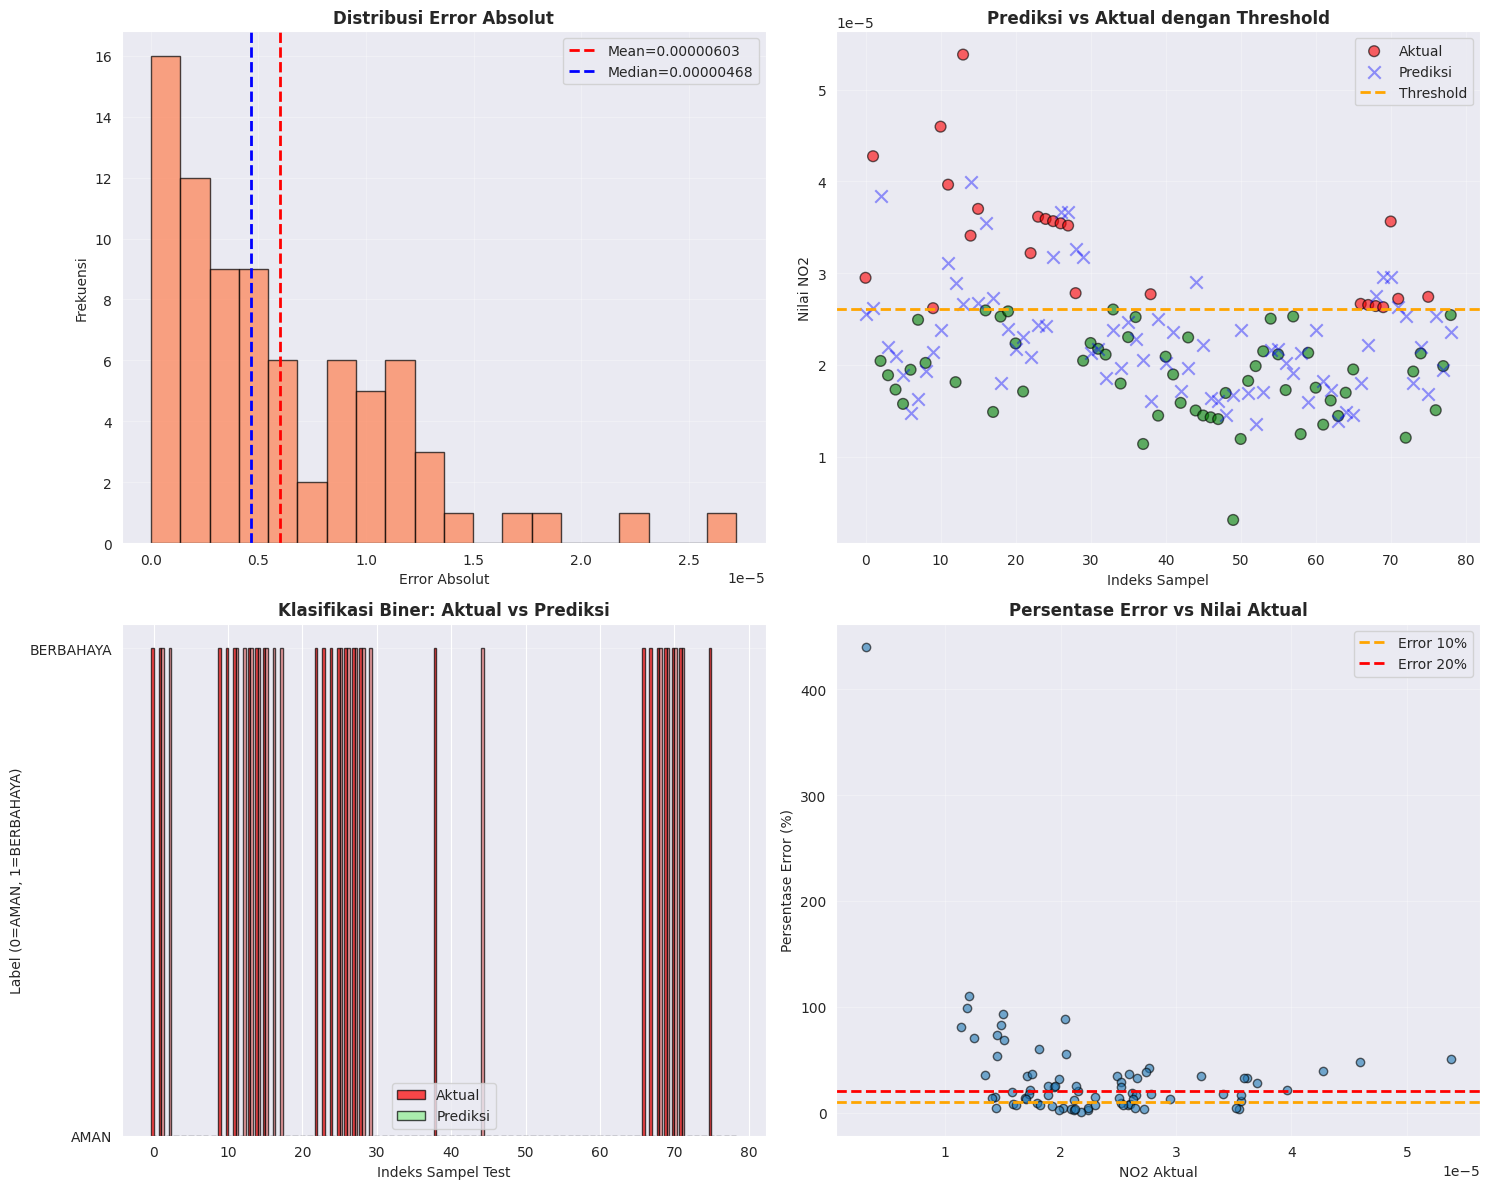


Visualisasi selesai


In [ ]:
print("\n" + "="*70)
print("LANGKAH 8: VISUALIZATION - PREDICTION ANALYSIS")
print("="*70)

# Analisis distribusi error
errors = np.abs(y_test - y_pred_regression)
mean_error = np.mean(errors)
median_error = np.median(errors)

print(f"\nAnalisis Error:")
print(f"  - Mean Absolute Error: {mean_error:.8f}")
print(f"  - Median Absolute Error: {median_error:.8f}")
print(f"  - Error Maksimum: {errors.max():.8f}")
print(f"  - Error Minimum: {errors.min():.8f}")

# Visualisasi
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Distribusi Error
axes[0, 0].hist(errors, bins=20, edgecolor='black', alpha=0.7, color='coral')
axes[0, 0].axvline(x=mean_error, color='red', linestyle='--', linewidth=2, label=f'Mean={mean_error:.8f}')
axes[0, 0].axvline(x=median_error, color='blue', linestyle='--', linewidth=2, label=f'Median={median_error:.8f}')
axes[0, 0].set_xlabel('Error Absolut')
axes[0, 0].set_ylabel('Frekuensi')
axes[0, 0].set_title('Distribusi Error Absolut', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Prediksi vs Aktual dengan kategori
colors_scatter = ['green' if val <= threshold else 'red' for val in y_test]
axes[0, 1].scatter(range(len(y_test)), y_test, alpha=0.6, label='Aktual', c=colors_scatter, edgecolors='k', s=60)
axes[0, 1].scatter(range(len(y_pred_regression)), y_pred_regression, alpha=0.4, label='Prediksi', marker='x', s=80, c='blue')
axes[0, 1].axhline(y=threshold, color='orange', linestyle='--', linewidth=2, label='Threshold')
axes[0, 1].set_xlabel('Indeks Sampel')
axes[0, 1].set_ylabel('Nilai NO2')
axes[0, 1].set_title('Prediksi vs Aktual dengan Threshold', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Hasil Klasifikasi Biner
x_pos = np.arange(len(y_test_binary))
width = 0.35
colors_actual = ['green' if x == 0 else 'red' for x in y_test_binary]
colors_pred = ['lightgreen' if x == 0 else 'lightcoral' for x in y_pred_binary]

axes[1, 0].bar(x_pos - width/2, y_test_binary, width, label='Aktual', color=colors_actual, alpha=0.7, edgecolor='black')
axes[1, 0].bar(x_pos + width/2, y_pred_binary, width, label='Prediksi', color=colors_pred, alpha=0.7, edgecolor='black')
axes[1, 0].set_xlabel('Indeks Sampel Test')
axes[1, 0].set_ylabel('Label (0=AMAN, 1=BERBAHAYA)')
axes[1, 0].set_title('Klasifikasi Biner: Aktual vs Prediksi', fontsize=12, fontweight='bold')
axes[1, 0].set_yticks([0, 1])
axes[1, 0].set_yticklabels(['AMAN', 'BERBAHAYA'])
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Plot 4: Persentase Error
percentage_error = (errors / y_test) * 100
axes[1, 1].scatter(y_test, percentage_error, alpha=0.6, edgecolors='k')
axes[1, 1].axhline(y=10, color='orange', linestyle='--', linewidth=2, label='Error 10%')
axes[1, 1].axhline(y=20, color='red', linestyle='--', linewidth=2, label='Error 20%')
axes[1, 1].set_xlabel('NO2 Aktual')
axes[1, 1].set_ylabel('Persentase Error (%)')
axes[1, 1].set_title('Persentase Error vs Nilai Aktual', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nVisualisasi selesai")

**💡 Penjelasan Singkat:**
- Analisis mendalam hasil prediksi melalui 4 visualisasi:
  1. **Distribusi Error**: Cek apakah error terdistribusi normal (model konsisten)
  2. **Prediksi vs Aktual**: Time series dengan warna berbeda untuk AMAN/BERBAHAYA
  3. **Klasifikasi Biner**: Bar chart untuk melihat sampel yang salah diprediksi
  4. **Persentase Error**: Cek apakah akurasi konsisten di semua range nilai

### LANGKAH 9: Prediksi Nilai NO2 Satu Hari Ke Depan

#### 📖 Penjelasan LANGKAH 9

**Tujuan:** Menggunakan model yang sudah dilatih untuk memprediksi nilai NO₂ **satu hari ke depan** (forecasting real).

**Proses Prediksi:**

1. **Ambil Data Input (3 Hari Terakhir):**
   - Dari dataset supervised, ambil **nilai original** (bukan yang ternormalisasi) dari baris terakhir
   - Data: `NO2(t-3), NO2(t-2), NO2(t-1)`
   - Ini adalah data paling terkini yang kita punya

2. **Normalisasi dengan Parameter Training:**
   - ⚠️ **PENTING:** Gunakan scaler yang sudah di-fit pada data training
   - **Jangan** fit ulang scaler pada data baru!
   - Ini memastikan skala yang konsisten dengan saat training

3. **Prediksi Nilai NO₂ (Regresi):**
   - Input: 3 nilai lag yang sudah ternormalisasi
   - Model KNN memprediksi nilai NO₂ kontinu untuk hari besok
   - Output: Nilai NO₂ dalam mol/m²

4. **Terapkan Threshold:**
   - Bandingkan prediksi NO₂ dengan threshold
   - Klasifikasi: AMAN atau BERBAHAYA
   - Hitung selisih dan persentase dari threshold

5. **Interpretasi:**
   - Status AMAN: NO₂ di bawah threshold → kualitas udara aman
   - Status BERBAHAYA: NO₂ di atas threshold → perlu tindakan pencegahan
   - Tingkat peringatan berdasarkan persentase selisih:
     - **>20%:** PERINGATAN TINGGI (sangat berbahaya)
     - **10-20%:** PERINGATAN SEDANG (berbahaya)
     - **0-10%:** PERINGATAN (perlu monitoring)
     - **<5% di bawah:** HATI-HATI (mendekati threshold)

**Visualisasi:**
- Bar chart menampilkan 3 hari terakhir + prediksi hari besok
- Warna: Hijau = AMAN, Merah = BERBAHAYA
- Threshold sebagai garis horizontal

**Output:** Prediksi nilai NO₂ hari besok dengan status klasifikasi dan level peringatan


LANGKAH 9: PREDIKSI NILAI NO2 SATU HARI KE DEPAN

Data 3 hari terakhir (Original):
  - NO2(t-3): 0.00002740 mol/m²
  - NO2(t-2): 0.00001505 mol/m²
  - NO2(t-1): 0.00001986 mol/m²

Data 3 hari terakhir (Ternormalisasi dengan parameter training):
  - NO2(t-3): 0.2191
  - NO2(t-2): 0.0969
  - NO2(t-1): 0.1445

HASIL PREDIKSI NO2 HARI BESOK (SATU HARI KE DEPAN)

[A] PREDIKSI NILAI NO2 (Regresi):
  - NO2 Prediksi: 0.00002354 mol/m²

[B] PENERAPAN THRESHOLD:
  - Threshold: 0.00002603 mol/m²
  - Status: AMAN
  - Selisih: -0.00000249 mol/m²
  - Persentase: -9.56% dari threshold

✓ AMAN: NO2 diprediksi 9.6% di bawah threshold
   → Kualitas udara dalam batas aman


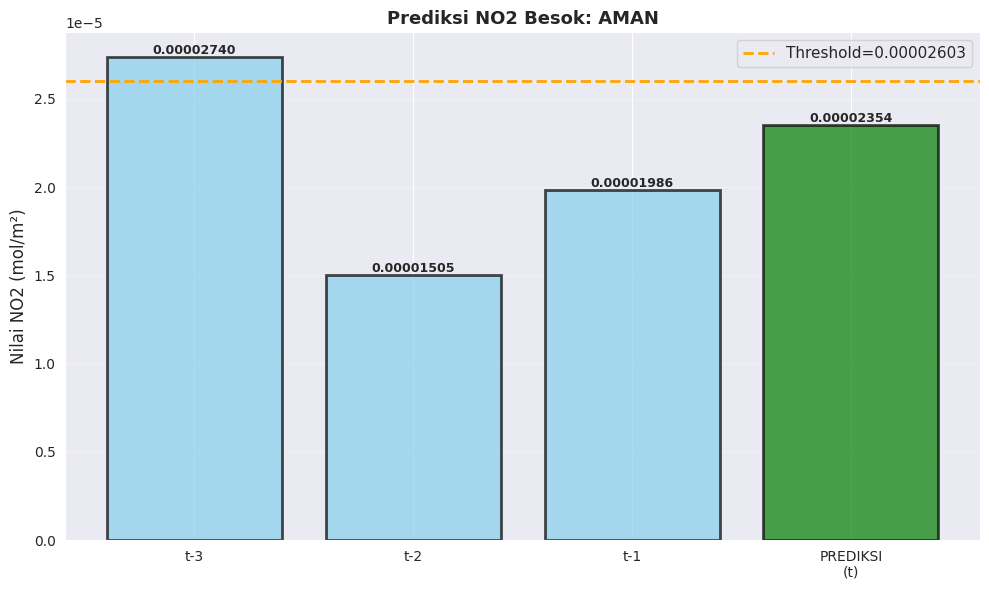

In [ ]:
print("\n" + "="*70)
print("LANGKAH 9: PREDIKSI NILAI NO2 SATU HARI KE DEPAN")
print("="*70)

# Ambil 3 hari terakhir dari supervised_df (data asli)
last_3_days_original = supervised_df[["NO2(t-3)", "NO2(t-2)", "NO2(t-1)"]].iloc[-1].values

print(f"\nData 3 hari terakhir (Original):")
print(f"  - NO2(t-3): {last_3_days_original[0]:.8f} mol/m²")
print(f"  - NO2(t-2): {last_3_days_original[1]:.8f} mol/m²")
print(f"  - NO2(t-1): {last_3_days_original[2]:.8f} mol/m²")

# Normalisasi menggunakan parameter dari data training
last_3_days_scaled = scaler.transform([last_3_days_original])[0]

print(f"\nData 3 hari terakhir (Ternormalisasi dengan parameter training):")
print(f"  - NO2(t-3): {last_3_days_scaled[0]:.4f}")
print(f"  - NO2(t-2): {last_3_days_scaled[1]:.4f}")
print(f"  - NO2(t-1): {last_3_days_scaled[2]:.4f}")

# Reshape untuk input model
X_tomorrow = last_3_days_scaled.reshape(1, -1)

# Prediksi nilai NO2 (regresi)
pred_no2_value = final_model.predict(X_tomorrow)[0]

# Terapkan threshold
pred_status = 'BERBAHAYA' if pred_no2_value > threshold else 'AMAN'
difference_from_threshold = pred_no2_value - threshold
percentage_diff = (difference_from_threshold / threshold) * 100

print("\n" + "="*70)
print("HASIL PREDIKSI NO2 HARI BESOK (SATU HARI KE DEPAN)")
print("="*70)
print(f"\n[A] PREDIKSI NILAI NO2 (Regresi):")
print(f"  - NO2 Prediksi: {pred_no2_value:.8f} mol/m²")

print(f"\n[B] PENERAPAN THRESHOLD:")
print(f"  - Threshold: {threshold:.8f} mol/m²")
print(f"  - Status: {pred_status}")
print(f"  - Selisih: {difference_from_threshold:.8f} mol/m²")
print(f"  - Persentase: {percentage_diff:+.2f}% dari threshold")

if pred_status == 'BERBAHAYA':
    if percentage_diff > 20:
        print(f"\n⚠ PERINGATAN TINGGI: NO2 diprediksi {percentage_diff:.1f}% DI ATAS threshold!")
        print(f"   → Prediksi SANGAT BERBAHAYA, ambil tindakan pencegahan!")
    elif percentage_diff > 10:
        print(f"\n⚠ PERINGATAN SEDANG: NO2 diprediksi {percentage_diff:.1f}% di atas threshold")
        print(f"   → Status BERBAHAYA, waspadai kualitas udara!")
    else:
        print(f"\n⚠ PERINGATAN: NO2 diprediksi {percentage_diff:.1f}% di atas threshold")
        print(f"   → Status BERBAHAYA, perlu monitoring!")
else:
    if abs(percentage_diff) < 5:
        print(f"\n✓ HATI-HATI: NO2 diprediksi hanya {abs(percentage_diff):.1f}% DI BAWAH threshold")
        print(f"   → Status masih AMAN, tapi mendekati batas ambang!")
    else:
        print(f"\n✓ AMAN: NO2 diprediksi {abs(percentage_diff):.1f}% di bawah threshold")
        print(f"   → Kualitas udara dalam batas aman")

# Visualisasi prediksi
fig, ax = plt.subplots(figsize=(10, 6))

# Plot 3 hari terakhir + prediksi
days = ['t-3', 't-2', 't-1', 'PREDIKSI\n(t)']
values = list(last_3_days_original) + [pred_no2_value]
colors_bar = ['skyblue', 'skyblue', 'skyblue', 'red' if pred_status == 'BERBAHAYA' else 'green']

bars = ax.bar(days, values, color=colors_bar, alpha=0.7, edgecolor='black', linewidth=2)
ax.axhline(y=threshold, color='orange', linestyle='--', linewidth=2, label=f'Threshold={threshold:.8f}')
ax.set_ylabel('Nilai NO2 (mol/m²)', fontsize=12)
ax.set_title(f'Prediksi NO2 Besok: {pred_status}', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

# Tambah label nilai di atas bar
for i, (bar, val) in enumerate(zip(bars, values)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.8f}',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*70)

### Ringkasan Hasil

In [ ]:
print("RINGKASAN PIPELINE NO2 PREDICTION (KNN REGRESSION)")


print(f"""
1. PENGUMPULAN DATA (Sentinel-5P OpenEO)
   - Lokasi: Bangkalan, Madura
   - Periode: {df['date'].min().date()} - {df['date'].max().date()}
   - Total sampel: {len(df)}
   - Output: timeseries.csv

2. PREPROCESSING (Interpolasi)
   - Missing values sebelum: {missing_before}
   - Missing values sesudah: {missing_after}
   - Metode: Interpolasi Linear

3. TRANSFORMASI SUPERVISED
   - Fitur lagged: {n_lags} lag
   - Fitur input: [NO2(t-3), NO2(t-2), NO2(t-1)]
   - Target: NO2(t)
   - Total sampel: {len(supervised_df)}

4. NORMALISASI
   - Metode: MinMaxScaler
   - Set training: {len(X_train)} sampel
   - Set testing: {len(X_test)} sampel

5. DEFINISI THRESHOLD
   - Threshold: {threshold:.8f} mol/m²
   - Persentil: ke-75

6. MODEL KNN REGRESSION (K={best_k})
   - MSE: {mse:.10f}
   - RMSE: {rmse:.8f}
   - MAE: {mae:.8f}
   - MAPE: {mape:.2f}%
   - R²: {r2:.4f}

7. PENERAPAN THRESHOLD (Metrik Klasifikasi)
   - Akurasi: {accuracy:.4f}
   - Presisi: {precision:.4f}
   - Recall: {recall:.4f}
   - F1-Score: {f1:.4f}

8. PREDIKSI HARI BESOK
   - NO2 Prediksi: {pred_no2_value:.8f} mol/m²
   - Threshold: {threshold:.8f} mol/m²
   - Status: {pred_status}
   - Selisih: {difference_from_threshold:+.8f} mol/m²
   - Persentase: {percentage_diff:+.2f}% dari threshold
""")

RINGKASAN PIPELINE NO2 PREDICTION (KNN REGRESSION)

1. PENGUMPULAN DATA (Sentinel-5P OpenEO)
   - Lokasi: Bangkalan, Madura
   - Periode: 2020-04-30 - 2021-05-30
   - Total sampel: 396
   - Output: timeseries.csv

2. PREPROCESSING (Interpolasi)
   - Missing values sebelum: 106
   - Missing values sesudah: 0
   - Metode: Interpolasi Linear

3. TRANSFORMASI SUPERVISED
   - Fitur lagged: 3 lag
   - Fitur input: [NO2(t-3), NO2(t-2), NO2(t-1)]
   - Target: NO2(t)
   - Total sampel: 393

4. NORMALISASI
   - Metode: MinMaxScaler
   - Set training: 314 sampel
   - Set testing: 79 sampel

5. DEFINISI THRESHOLD
   - Threshold: 0.00002603 mol/m²
   - Persentil: ke-75

6. MODEL KNN REGRESSION (K=9)
   - MSE: 0.0000000001
   - RMSE: 0.00000759
   - MAE: 0.00000576
   - MAPE: 31.11%
   - R²: 0.2214

7. PENERAPAN THRESHOLD (Metrik Klasifikasi)
   - Akurasi: 0.8228
   - Presisi: 0.7368
   - Recall: 0.6087
   - F1-Score: 0.6667

8. PREDIKSI HARI BESOK
   - NO2 Prediksi: 0.00002181 mol/m²
   - Threshold

## IMPLEMENTASI MODEL (Deployment)

### LANGKAH 10: Simpan Model untuk Deployment

**💡 Penjelasan Singkat:**
- Menyimpan model KNN dan scaler ke file .pkl
- Model siap digunakan untuk produksi/deployment
- Informasi lengkap hyperparameter dan performa model

In [ ]:
print("=" * 70)
print("LANGKAH 10: SIMPAN MODEL UNTUK DEPLOYMENT")
print("=" * 70)

import joblib

# Simpan model dan scaler
joblib.dump(final_model, 'knn_model.pkl')
joblib.dump(scaler, 'minmax_scaler.pkl')

print("\n✓ Model berhasil disimpan:")
print(f"  - knn_model.pkl (Model KNN K={best_k})")
print(f"  - minmax_scaler.pkl (MinMaxScaler)")
print(f"  - Threshold: {threshold:.8f} mol/m²")

# Tampilkan informasi model
print(f"\nInformasi Model:")
print(f"  - Algoritma: KNN Regression")
print(f"  - Hyperparameter: K={best_k}, weights='{best_weights}', metric='{best_metric}'")
print(f"  - MSE: {mse:.10f}")
print(f"  - R²: {r2:.4f}")
print(f"  - Input fitur: 3 lag [NO2(t-3), NO2(t-2), NO2(t-1)]")

print("\n✓ Model siap untuk deployment!")

LANGKAH 10: SIMPAN MODEL UNTUK DEPLOYMENT

✓ Model berhasil disimpan:
  - knn_model.pkl (Model KNN K=5)
  - minmax_scaler.pkl (MinMaxScaler)
  - Threshold: 0.00002603 mol/m²

Informasi Model:
  - Algoritma: KNN Regression
  - Hyperparameter: K=5, weights='uniform', metric='manhattan'
  - MSE: 0.0000000001
  - R²: 0.1300
  - Input fitur: 3 lag [NO2(t-3), NO2(t-2), NO2(t-1)]

✓ Model siap untuk deployment!


### LANGKAH 11: Implementasi - Prediksi Data Baru (Contoh Sederhana)

**💡 Penjelasan Singkat:**
- Load model dan scaler yang sudah disimpan
- Prediksi dengan data baru (3 hari terakhir NO₂)
- Klasifikasi berdasarkan threshold: AMAN atau BERBAHAYA

In [ ]:
print("=" * 70)
print("CONTOH IMPLEMENTASI: PREDIKSI DATA BARU")
print("=" * 70)

# Simulasi data baru (3 hari terakhir NO₂)
data_baru = np.array([[0.00008, 0.00009, 0.00010]])  # NO2(t-3), NO2(t-2), NO2(t-1)

# Load model dan scaler
loaded_scaler = joblib.load('minmax_scaler.pkl')
loaded_model = joblib.load('knn_model.pkl')

print(f"\n✓ Model berhasil dimuat:")
print(f"  - Model: KNN Regression (K={best_k})")
print(f"  - Scaler: MinMaxScaler")

# Proses prediksi
print(f"\nInput Data (3 hari terakhir):")
print(f"  - NO2(t-3): {data_baru[0,0]:.8f} mol/m²")
print(f"  - NO2(t-2): {data_baru[0,1]:.8f} mol/m²")
print(f"  - NO2(t-1): {data_baru[0,2]:.8f} mol/m²")

# Normalisasi dan prediksi
data_normalized = loaded_scaler.transform(data_baru)
pred_no2 = loaded_model.predict(data_normalized)[0]

# Evaluasi dengan threshold
if pred_no2 <= threshold:
    status = "AMAN"
    status_color = "green"
else:
    status = "BERBAHAYA"
    status_color = "red"

difference = pred_no2 - threshold
percentage = (difference / threshold) * 100

print(f"\n{'='*70}")
print("HASIL PREDIKSI")
print(f"{'='*70}")
print(f"  - Prediksi NO₂: {pred_no2:.8f} mol/m²")
print(f"  - Threshold: {threshold:.8f} mol/m²")
print(f"  - Status: {status}")
print(f"  - Selisih: {difference:+.8f} mol/m² ({percentage:+.2f}%)")

print("\n✓ Implementasi berhasil!")

CONTOH IMPLEMENTASI: PREDIKSI DATA BARU

✓ Model berhasil dimuat:
  - Model: KNN Regression (K=5)
  - Scaler: MinMaxScaler

Input Data (3 hari terakhir):
  - NO2(t-3): 0.00008000 mol/m²
  - NO2(t-2): 0.00009000 mol/m²
  - NO2(t-1): 0.00010000 mol/m²

HASIL PREDIKSI
  - Prediksi NO₂: 0.00006406 mol/m²
  - Threshold: 0.00002603 mol/m²
  - Status: BERBAHAYA
  - Selisih: +0.00003804 mol/m² (+146.16%)

✓ Implementasi berhasil!


### LANGKAH 12: Deployment - Testing Berbagai Skenario

**💡 Penjelasan Singkat:**
- Testing dengan 3 skenario berbeda: Rendah, Sedang, Tinggi
- Visualisasi timeline prediksi dengan grafik bar
- Perbandingan dengan threshold untuk klasifikasi
- Output visual memudahkan interpretasi hasil

DEPLOYMENT: TESTING BERBAGAI SKENARIO

Testing berbagai skenario dengan data statis:

Pilih skenario test:
1. Skenario 1 - Rendah (AMAN):
   NO2(t-3)=0.00001301, NO2(t-2)=0.00001562, NO2(t-1)=0.00001822
2. Skenario 2 - Sedang (MENDEKATI THRESHOLD):
   NO2(t-3)=0.00002212, NO2(t-2)=0.00002342, NO2(t-1)=0.00002472
3. Skenario 3 - Tinggi (BERBAHAYA):
   NO2(t-3)=0.00002863, NO2(t-2)=0.00003123, NO2(t-1)=0.00003383

MENGGUNAKAN: Skenario 2 - Sedang (MENDEKATI THRESHOLD)
NO2(t-3): 0.00002212 mol/m²
NO2(t-2): 0.00002342 mol/m²
NO2(t-1): 0.00002472 mol/m²

HASIL PREDIKSI
  - Prediksi NO₂: 0.00002183 mol/m²
  - Threshold: 0.00002603 mol/m²
  - Status: [AMAN]
  - Selisih: -0.00000420 mol/m² (-16.14%)


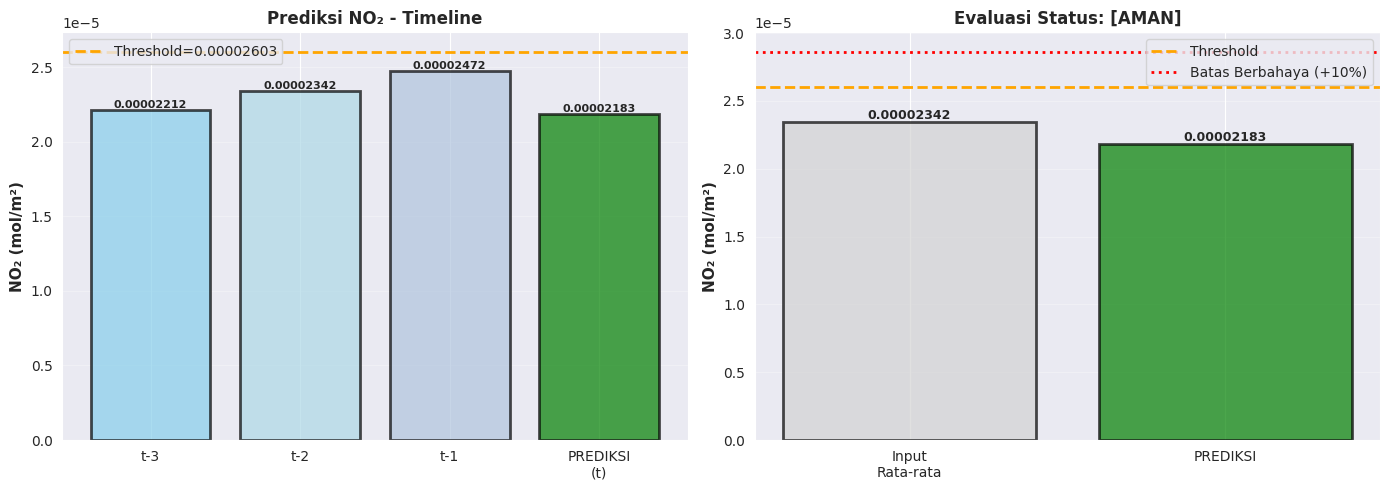


✓ Deployment completed: [AMAN]


In [ ]:
print("=" * 70)
print("DEPLOYMENT: TESTING BERBAGAI SKENARIO")
print("=" * 70)

# Data input statis - berbagai skenario pengujian
print("\nTesting berbagai skenario dengan data statis:")

# Definisikan skenario test berdasarkan data aktual
threshold_val = threshold

test_scenarios = {
    "Skenario 1 - Rendah (AMAN)": [
        threshold_val * 0.5,  # 50% dari threshold
        threshold_val * 0.6,
        threshold_val * 0.7
    ],
    "Skenario 2 - Sedang (MENDEKATI THRESHOLD)": [
        threshold_val * 0.85,  # 85% dari threshold
        threshold_val * 0.90,
        threshold_val * 0.95
    ],
    "Skenario 3 - Tinggi (BERBAHAYA)": [
        threshold_val * 1.10,  # 110% dari threshold
        threshold_val * 1.20,
        threshold_val * 1.30
    ]
}

print("\nPilih skenario test:")
for i, (name, values) in enumerate(test_scenarios.items(), 1):
    print(f"{i}. {name}:")
    print(f"   NO2(t-3)={values[0]:.8f}, NO2(t-2)={values[1]:.8f}, NO2(t-1)={values[2]:.8f}")

# Gunakan skenario pertama sebagai default, atau ubah untuk test lain
selected_scenario = "Skenario 2 - Sedang (MENDEKATI THRESHOLD)"  # Ubah ini untuk test berbeda
data_input = test_scenarios[selected_scenario]

print(f"\n{'='*70}")
print(f"MENGGUNAKAN: {selected_scenario}")
print(f"{'='*70}")
print(f"NO2(t-3): {data_input[0]:.8f} mol/m²")
print(f"NO2(t-2): {data_input[1]:.8f} mol/m²")
print(f"NO2(t-1): {data_input[2]:.8f} mol/m²")

data_baru_test = np.array([data_input])

# Load model dan scaler
scaler_deploy = joblib.load('minmax_scaler.pkl')
model_deploy = joblib.load('knn_model.pkl')

# Normalisasi dan prediksi
data_scaled = scaler_deploy.transform(data_baru_test)
prediksi_no2 = model_deploy.predict(data_scaled)[0]

# Evaluasi dengan threshold
if prediksi_no2 <= threshold_val:
    status_final = "AMAN"
    color_status = 'green'
elif prediksi_no2 <= threshold_val * 1.1:
    status_final = "PERHATIAN"
    color_status = 'orange'
else:
    status_final = "BERBAHAYA"
    color_status = 'red'

diff_threshold = prediksi_no2 - threshold_val
pct_threshold = (diff_threshold / threshold_val) * 100

print(f"\n{'='*70}")
print("HASIL PREDIKSI")
print(f"{'='*70}")
print(f"  - Prediksi NO₂: {prediksi_no2:.8f} mol/m²")
print(f"  - Threshold: {threshold_val:.8f} mol/m²")
print(f"  - Status: [{status_final}]")
print(f"  - Selisih: {diff_threshold:+.8f} mol/m² ({pct_threshold:+.2f}%)")

# Visualisasi Aktual vs Prediksi
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Time series dengan prediksi
days = ['t-3', 't-2', 't-1', 'PREDIKSI\n(t)']
values = list(data_baru_test[0]) + [prediksi_no2]
colors = ['skyblue', 'lightblue', 'lightsteelblue', color_status]

bars1 = ax1.bar(days, values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax1.axhline(threshold_val, color='orange', linestyle='--', linewidth=2, 
            label=f'Threshold={threshold_val:.8f}')
ax1.set_ylabel('NO₂ (mol/m²)', fontsize=11, fontweight='bold')
ax1.set_title('Prediksi NO₂ - Timeline', fontsize=12, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3, axis='y')

for bar, val in zip(bars1, values):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height,
             f'{val:.8f}', ha='center', va='bottom', fontsize=8, fontweight='bold')

# Plot 2: Perbandingan dengan threshold
comparison_labels = ['Input\nRata-rata', 'PREDIKSI']
comparison_values = [np.mean(data_baru_test[0]), prediksi_no2]
comparison_colors = ['lightgray', color_status]

bars2 = ax2.bar(comparison_labels, comparison_values, color=comparison_colors, 
                alpha=0.7, edgecolor='black', linewidth=2)
ax2.axhline(threshold_val, color='orange', linestyle='--', linewidth=2, 
            label=f'Threshold')
ax2.axhline(threshold_val * 1.1, color='red', linestyle=':', linewidth=2, 
            label='Batas Berbahaya (+10%)')
ax2.set_ylabel('NO₂ (mol/m²)', fontsize=11, fontweight='bold')
ax2.set_title(f'Evaluasi Status: [{status_final}]', fontsize=12, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')

for bar, val in zip(bars2, comparison_values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, height,
             f'{val:.8f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n{'='*70}")
print(f"✓ Deployment completed: [{status_final}]")
print(f"{'='*70}")

## 🔗 Akses Aplikasi Prediksi NO₂

Klik untuk membuka aplikasi Streamlit:

👉 [Buka Aplikasi Prediksi NO₂](https://prediksi-nilai-no2-satu-hari-kedepan.streamlit.app/)
